[Original Source Code](https://github.com/richliao/textClassifier/blob/master/textClassifierConv.py)

### 1. Import Necessary libraries -> numpy,os,Keras Dense,Conv1D,MaxPooling1D, Embedding,Merge,Dropout layers, pandas libraries

In [2]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten,Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model
from keras.layers import GlobalMaxPooling1D
from keras.models import Sequential

from keras.models import model_from_json

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 2. Read dev__.csv data as  pandas dataframe

In [2]:
data = pd.read_csv('dev__.csv') # Reading dev_.csv data as a dataframe
data.head(n=15) # display first 15 rows of the dataframe-> data

,file,line,word,entity_type,aggregation_type,filter_condition
0,dev,What position does the player who played for b...,What,O,0.0,0.0
1,dev,What position does the player who played for b...,position,O,0.0,0.0
2,dev,What position does the player who played for b...,does,O,0.0,0.0
3,dev,What position does the player who played for b...,the,O,0.0,0.0
4,dev,What position does the player who played for b...,player,O,0.0,0.0
5,dev,What position does the player who played for b...,who,O,0.0,0.0
6,dev,What position does the player who played for b...,played,O,0.0,0.0
7,dev,What position does the player who played for b...,for,O,0.0,0.0
8,dev,What position does the player who played for b...,butler,B-FILTER_VAL,0.0,0.0
9,dev,What position does the player who played for b...,cc,B-FILTER_VAL,0.0,0.0


In this dataframe we have columns:
1. file -> dev
2. line -> Display sentences in a line.
3. word -> Displays each word in a line.
4. entity_type-> 
                (1) We have O ->It means other words that is not a filter.
                (2) We have B-FILTER_VAL -> It means that the word is a filter.
                (3) NaN -> Not A Number -> Not specified.
5. aggregation_type->
                (0) Aggregation operation -> It computes a single value from a collection of values.
                (1) dev__.csv has been extracted from https://github.com/salesforce/WikiSQL/blob/master/data.tar.bz2
                (2) Here the aggregation_type thats been present in original data(https://github.com/salesforce/WikiSQL/blob/master/data.tar.bz2) is ['NONE','MAX','MIN','COUNT','SUM','AVG']
                (3) We have processed the original data aggregation type ['NONE','MAX','MIN','COUNT','SUM','AVG'] to [0,1,2,3,4,5] in dev__.csv
                
6. filter_condition

Here dev__.csv is a validation dataset.

### 3. Create a new dataframe agg_data that has line,aggregation_type column from data dataframe

In [3]:
agg_data = data[['line','aggregation_type']]
agg_data.head(15) # Displaying the first 15 rows

,line,aggregation_type
0,What position does the player who played for b...,0.0
1,What position does the player who played for b...,0.0
2,What position does the player who played for b...,0.0
3,What position does the player who played for b...,0.0
4,What position does the player who played for b...,0.0
5,What position does the player who played for b...,0.0
6,What position does the player who played for b...,0.0
7,What position does the player who played for b...,0.0
8,What position does the player who played for b...,0.0
9,What position does the player who played for b...,0.0


### 4. Drop duplicate rows and NaN rows from agg_data dataframe

In [4]:
agg_data = agg_data.drop_duplicates().dropna()
agg_data.head(15) # Displaying first 15 rows in the dataframe

,line,aggregation_type
0,What position does the player who played for b...,0.0
13,How many schools did player number 3 play at?,3.0
23,What school did player number 21 play for?,0.0
32,Who is the player that wears number 42?,0.0
41,What player played guard for toronto in 1996-97?,0.0
50,Who are all of the players on the Westchester ...,0.0
64,What school/club team is Amir Johnson on?,0.0
72,What are the total amount of numbers on the To...,3.0
86,What are the total number of positions on the ...,3.0
100,What are the nationality of the players on the...,0.0


In [5]:
print("Shape of agg_data dataframe:",agg_data.shape) # Shape of aggregation_data dataframe

Shape of agg_data dataframe: (8391, 2)


### 5. Loading Google's Pre-trained Word2Vec Model

In [5]:
# Import keyedVectors from gensim library
from gensim.models import KeyedVectors
word_vector_model = KeyedVectors.load_word2vec_format ('./word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)

C:\ProgramData\Anaconda3\lib\site-packages\gensim-3.2.0-py3.6-win-amd64.egg\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### 6. Now checking the shape of the words present in the pretrained Word2Vec model dictionary

In [6]:
dog = word_vector_model['dog']
print("General Shape of word -> dog",dog.shape)
print(dog[:10])

General Shape of word -> dog (300,)
[ 0.05126953 -0.02233887 -0.17285156  0.16113281 -0.08447266  0.05737305
  0.05859375 -0.08251953 -0.01538086 -0.06347656]


Here we can come to conclusion that all the words that is present in word_vector_model dictionary has shape (300,)

### 7. Now checking with out of words in word_vector_model dictionary

In [8]:
# Deal with an out of dictionary word: Михаил (Michail)
if 'Михаил' in word_vector_model:
    print(word_vector_model['Михаил'].shape)
else:
    print('{0} is an out of dictionary word'.format('Михаил'))

Михаил is an out of dictionary word


### 8. Define Sequence length, top n words(MAX_NB_WORDS), embedding_dim,validation_split

In [9]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000 # top-n words -> Here we are specifying top 20000 words.
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2 # 20% of data is used for validation.

### 9. Storing the dataframe columns(line,aggregation_type) as a list in text,labels

In [10]:
texts = agg_data.line.tolist()
labels = agg_data.aggregation_type.tolist()

In [11]:
print("The Length of texts list:",len(texts))
print("The Length of the labels list:",len(labels))

The Length of texts list: 8391
The Length of the labels list: 8391


In [12]:
# displaying first 5 texts and 5 labels
for i in range(0,5):
    print(texts[i],labels[i])

What position does the player who played for butler cc (ks) play? 0.0
How many schools did player number 3 play at? 3.0
What school did player number 21 play for? 0.0
Who is the player that wears number 42? 0.0
What player played guard for toronto in 1996-97? 0.0


### 10. Tokenizer
The Tokenizer class in Keras has various methods which help to prepare text so it can be used in neural network models.

In [13]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts) # Training phase is by means fit_on_texts method.
sequences = tokenizer.texts_to_sequences(texts) # Turns text into a numerical array.

word_index = tokenizer.word_index # Gives the index of every word in the corpus(texts).
#print(word_index)
print("The length of sequences:",len(sequences))
print(texts[0]) # Priniting texts -> at index 0
print("\nConverting the sentences into word index as that of index contained in words in tokenizer.word_index:")
print(sequences[0]) # We convert texts into numerical array -> contains word_indexes of the texts


first_text = texts[0] 
first_text = first_text.split()
# print(type(word_index)) # dictionary


# Here we test with 1st sentence of text corpa->with word_index dictionary
for i in range(0,len(first_text)):
    if first_text[i].lower() in word_index:
        print(word_index[first_text[i].lower()],end=',')


C:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


The length of sequences: 8391
What position does the player who played for butler cc (ks) play?

Converting the sentences into word index as that of index contained in words in tokenizer.word_index:
[2, 55, 132, 1, 38, 18, 52, 9, 2463, 1855, 3774, 96]
2,55,132,1,38,18,52,9,2463,1855,

In [14]:
print('Found %s unique tokens.' % len(word_index))

Found 9096 unique tokens.


### 11. Pad the sequences to get the same length on all of them

After mapping every questions to sequences of word embedding, we need to pad the sequences to get the same length on all of them.i.e. we add zeroes to the small sequences and truncate the larger ones.

In [15]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) # 8391,1000
print(data.shape)

(8391, 1000)


In [16]:
print(data)

[[   0    0    0 ... 1855 3774   96]
 [   0    0    0 ...   37   96   46]
 [   0    0    0 ...  123   96    9]
 ...
 [   0    0    0 ...   32    5  738]
 [   0    0    0 ... 1695 9096 2556]
 [   0    0    0 ...    3    5  738]]


### 12. The labels are converted to index vectors in order to use categorical crossentropy.

In [17]:
labels = to_categorical(np.asarray(labels))
print(labels)

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [18]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (8391, 1000)
Shape of label tensor: (8391, 6)


### 13. Apply Shuffle to the data and labels for training the model

Most of the times the neural network tries to prefer memorizing instead of learning. So we shuffle our data inorder for the neural networks to learn.

In [19]:
indices = np.arange(data.shape[0]) # No of rows
print(indices)

[   0    1    2 ... 8388 8389 8390]


In [20]:
# Shuffling the indices
np.random.shuffle(indices) #shuffle the rows
print(indices)

[4961 6522 3023 ... 5913 2959 7491]


In [21]:
# Before shuffling -> data
print(data)

[[   0    0    0 ... 1855 3774   96]
 [   0    0    0 ...   37   96   46]
 [   0    0    0 ...  123   96    9]
 ...
 [   0    0    0 ...   32    5  738]
 [   0    0    0 ... 1695 9096 2556]
 [   0    0    0 ...    3    5  738]]


In [22]:
# After shuffling -> data
data = data[indices] #Apply shuffle to data
print(data)

[[   0    0    0 ...  187   47   13]
 [   0    0    0 ...    7 7925  394]
 [   0    0    0 ...   20    4 1432]
 ...
 [   0    0    0 ...   13 2574 3492]
 [   0    0    0 ...   28    2  145]
 [   0    0    0 ...   15    4 2425]]


In [23]:
# Before Shuffling -> labels
print(labels)

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [24]:
# After shuffling -> labels
labels = labels[indices] # Apply shuffle to labels
print(labels)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


### 14. Use last 1678 samples from the data  list for validation and you must not include those data in training.

What is the point of validating? If you include the validation data for training. How can you measure the learning process?
So we are choosing the last 1678 samples from data list for validation and these samples are not included in the training.


In [25]:
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])  # 0.2 * 8391
print("Total Validation samples:",nb_validation_samples)

Total Validation samples: 1678


In [26]:
# Python slice notaion
#a[:-2] # everything except last two items
#a[-2:] # last two items in the array
data.shape

(8391, 1000)

We need to train everything in the data list except last 1678 elements which left for validation of our learning.

In [27]:
# Choosing Training samples,labels -> not including last 1678 samples which is left for validation.
x_train = data[:-nb_validation_samples] # Everything except the last 1678 samples
y_train = labels[:-nb_validation_samples]


In [28]:
# Validation data -> Contains last 1678 samples
x_val = data[-nb_validation_samples:] # last 1678 samples
y_val = labels[-nb_validation_samples:] # last 1678 samples

In [29]:
print(y_train)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [30]:
print(y_val)

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [31]:
# Summing over columns in training and validation labels
print('Number of categories of each aggregation type in training and validation set ')
# To sum over cloumns ->.sum(axis=0)
print (y_train.sum(axis=0))
print (y_val.sum(axis=0))

Number of categories of each aggregation type in training and validation set 
[4798.  419.  377.  601.  257.  261.]
[1193.   86.   90.  178.   63.   68.]


### 15. Creating embedding matrix that contains word_index words that is present in google pretrained word2vec model dictionary:

The embedding_matrix matrix maps words to vectors in the specified embedding dimension (here 300):

In [33]:
# The embedding matrix is default filled with 0 value in the dimension of (9096,300)


embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))# Create a 0 matrix of shape (9096,300)
print(embedding_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
print(word_index)

{'the': 1, 'what': 2, 'is': 3, 'of': 4, 'a': 5, 'and': 6, 'was': 7, 'than': 8, 'for': 9, 'when': 10, 'has': 11, 'with': 12, 'in': 13, 'which': 14, 'team': 15, 'name': 16, 'number': 17, 'who': 18, 'how': 19, 'score': 20, 'many': 21, 'that': 22, 'total': 23, 'game': 24, '1': 25, 'on': 26, 'less': 27, 'had': 28, 'date': 29, '2': 30, 'did': 31, 'as': 32, 'an': 33, 'points': 34, '0': 35, 'year': 36, '3': 37, 'player': 38, 'are': 39, 'average': 40, 'home': 41, 'larger': 42, 'were': 43, '4': 44, 'more': 45, 'at': 46, '5': 47, 'have': 48, 'smaller': 49, 'where': 50, 'rank': 51, 'played': 52, 'record': 53, 'to': 54, 'position': 55, "what's": 56, 'result': 57, 'from': 58, '8': 59, '6': 60, 'time': 61, 'away': 62, 'highest': 63, '7': 64, 'episode': 65, 'opponent': 66, '9': 67, 'attendance': 68, '10': 69, 'lowest': 70, 'by': 71, 'against': 72, 'round': 73, 'greater': 74, 'country': 75, 'there': 76, 'week': 77, 'season': 78, 'goals': 79, 'won': 80, 'pick': 81, 'place': 82, '12': 83, 'venue': 84, '1

### 16. Storing word_index that has only google pretrained word2vec words in embedding_matrix

In [35]:
for word, i in word_index.items():
    # embedding_vector = embeddings_index.get(word) # Correct it
    try:
        embedding_matrix[i]=word_vector_model[word]
    except:
        # words
        x = 1

In [36]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.08007812  0.10498047  0.04980469 ...  0.00366211  0.04760742
  -0.06884766]
 [ 0.13964844 -0.00616455  0.21484375 ...  0.05712891  0.09960938
  -0.234375  ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [37]:
print("shape of embedding_matrix:",embedding_matrix.shape)

shape of embedding_matrix: (9097, 300)


### 17. The model
Here we used a 3-layered convolution neural network with 2 dense layers.

Why Convolutional? Because it works. Convolutional layers are really powerful to extract higher level feature in images. And quite amazingly, they actually work in most 2D problems. Another big reason that should convince you is the training time, CNN train 50% to 60% faster than LSTMs on this problem.

In [47]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH, # 1000
                            trainable=True))
model.add(Dropout(0.2))

model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))


model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))

model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - simplified convolutional neural network")
model.summary()


model fitting - simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 300)         2729100   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000, 300)         0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 996, 128)          192128    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 199, 128)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 39, 128)           0         
_________________________________________________________________
conv1d_20 (Conv1D)  

In [52]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=128)

Train on 6713 samples, validate on 1678 samples
Epoch 1/3
6713/6713 [==============================] - 301s 45ms/step - loss: 0.4342 - acc: 0.8574 - val_loss: 0.4660 - val_acc: 0.8564
Epoch 2/3
6713/6713 [==============================] - 301s 45ms/step - loss: 0.3561 - acc: 0.8825 - val_loss: 0.4344 - val_acc: 0.8683
Epoch 3/3
6713/6713 [==============================] - 295s 44ms/step - loss: 0.2925 - acc: 0.9056 - val_loss: 0.4432 - val_acc: 0.8576


### 18. Plotting the results

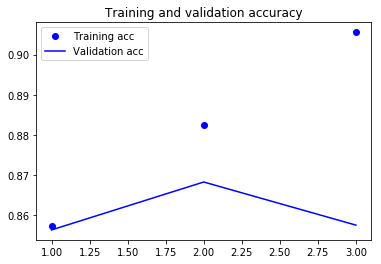

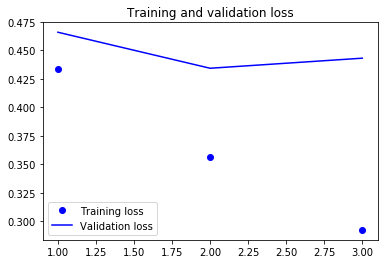

In [53]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 19. Save and Load Your Keras Deep Learning Models

Keras separates the concerns of saving your model architecture and saving your model weights.
- Model weights are saved to HDF5 format. This is a grid format that is ideal for storing multi-dimensional arrays of numbers.
- Model structure is stored in JSON

In [49]:
# serialize model to JSON
model_json = model.to_json()
with open("./data/agg_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./data/agg_model_weights.h5")
print("Saved model to disk")

Saved model to disk


### 20. Loading the saved model

In [3]:
# load json and create model
json_file = open('./data/agg_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./data/agg_model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


### 21. Making Predictions


In [4]:
question =['show maximum profits in the last 3 years']
sequences = tokenizer.texts_to_sequences(question) # Which turns input into numerical array -> Contains word_index of text
print(sequences)

NameError: name 'tokenizer' is not defined

In [ ]:
#  we need to pad the sequences to get the same length on all of them
# .i.e. we add zeroes to the small sequences and truncate the larger ones.
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) # sequences ->1(Since a single sentence),maxlen =1000
print(data.shape)

In [ ]:
# using loaded_model to predict the data thats been padded
predict = loaded_model.predict(data, batch_size=10, verbose=0)
print(predict)

In [82]:
predict = predict[0].tolist()

In [83]:
# The argumentation list
arg_list = ['NONE', 'MAX', 'MIN', 'COUNT', 'SUM', 'AVG']
predict.index(max(predict)) # .index -> returns the lowest index in the string where substring is found.

1

In [84]:
prediction = arg_list[predict.index(max(predict))]
print(prediction)

MAX
